In [117]:
# I installed needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings(action='ignore')

## Data Loading
과제 4,5,6과 동일

In [118]:
# adjacency matrix 데이터를 삽입할 dataframe을 정의합니다. 
df = np.zeros((34,34))

# 본래 list로 작성된 adjacency data를 행려롤 전환
with open("karate_club.adjlist") as file:
    for _ in range(3):
        next(file)
        
# 파일의 줄마다 pair를 찾고 있을 시 1을 부여
    for line in file:
        node = list(map(int, line.split()))
        i = node[0]
        for j in node[1:]:
            df[i][j] = 1
            df[j][i] = 1
    file.close()
    
label = np.loadtxt("karate_label.txt")

## Matrix Factorization
과제 4와 동일한 Class 사용

In [119]:
# Define the class for MatrixFactoriztion
class MatrixFactorization():
    
# "Define _init_ to set initial variables. 
    """
    A : adjacency matrix
    epoch : How many epochs
    d : dimension of embedding vector (set default 4, suggested by assignment)
    lr : learning rate (set 0.01 as default, no reason)
    random_state : ranom_state, just to incorporate choice for randomness
    """
    def __init__(self, A,  epoch, d = 4, lr=0.01,random_state = 42):
        self.A = A
        self.d = d
        self.lr = lr
        self.epoch = epoch
        np.random.seed(random_state)
        
        """ 
        self.U and self.V are initial setting for z_u and z_v. 
        I give them random values, made on normal dist.
        """
        self.U = np.random.normal(0,0.03, [A.shape[0], d])
        self.V = self.U.T

        """
        I iterated the matrix by pair of (i,j). 
        So,  convenience later, I made index matrix
        """
        # get length of Adjacency matrix
        index_i = range(A.shape[0]) ;index_j = range(A.shape[0])
        A_index = []
        # Put all paris into index matrix 
        for i in index_i:
            for j in index_j:
                A_index.append((i,j))
        # Randomly shuffle the index to give more randomness
        np.random.shuffle(A_index)
        self.index = A_index
        self.cost = []
        
    """ 
    Iterate over indexes
    calculate z_u * z_v, and calculate the diffrence with real adjacency matrix, 
    do backpropagetion , repeat with (j,i) again
    """    
    def sgd(self):
        cost = []
        for epoch in range(self.epoch):
            for i,j in self.index:
                #propagation
                A_ij_hat = np.dot(self.U[i] , self.V[:,j])
                #calculate gradient
                grad_u = (self.A[i][j] - A_ij_hat) * self.V[:,j]
                grad_v = (self.A[i][j] - A_ij_hat) * self.U[i]
                #backpropagation
                self.U[i]   += self.lr * grad_u
                self.V[:,j] += self.lr * grad_v
            #repeat for (j,i)
                #propagation
                A_ji_hat = np.dot(self.U[i] , self.V[:,j])
                #calculate gradient
                grad_u2 = (self.A[j][i] - A_ij_hat) * self.V[:,i]
                grad_v2 = (self.A[j][i] - A_ij_hat) * self.U[j]
                #backpropagation
                self.U[j]   += self.lr * grad_u2
                self.V[:,i] += self.lr * grad_v2

            #The resulted embedding matrix
            A_hat = np.dot(self.U , self.V)
            # get cost for each epochs
            self.cost.append(np.sum((self.A-A_hat)**2/np.prod(self.A.shape)))

## Deepwalk with hierarchical tree & without hierarchical tree
과제 5,6과 동일한 class 사용

In [120]:
def randomwalks(G,root,t=10):
    walks = [root]
    
    for _ in range(t-1):
        # 랜덤워크가 시작될 노드 설정
        root_node = G[:,root]
        
        # 연결될 노드를 저장할 리스트
        connect = []
        
        # 연결된 노드 중 임의의 노드를 뽑아냄.
        # enumerate,를 사용해 1의 값을 갖는 노드의 레이블을 저장
        for index, connection in enumerate(root_node):
            if connection ==1:
                connect.append(index)
                
        # t번 반복해야 하므로, 다음 노드 중 하나를 next로 저장하여 다시 시작
        next = np.random.choice(connect,1)[-1]
        walks.append(next)
        root = next       
        
    return walks

def path(leaf_node):
    #후에 node들의 번호를 path에 저장
    path = []
    #각 node가 왼쪽방향인지, 오른쪽 방향인지 저장. 1이면 왼쪽, -1이면 오른쪽
    path_sign = [] 
    
    #path를 따라 움직이면서, 현재 node를 의미한다는 뜻으로 current_node 설정
    current_node = leaf_node
    #leaf_node가 1이면 맨 위 노드이므로 진행하지 않으며,
    #leaf_noder가 1 초과이면 parent가 있다는 뜻이므로 진행한다. 
    while True:
        #현재 node가 1이라면 맨 위 노드에 위치해있으므로 더이상 구할 path가 없다.
        if current_node ==1:
            break
            
        #수업시간에 배운 tree가 binary tree이므로, leaf_node가 짝수이면 왼쪽, 홀수이면 오른쪽으로 갈라진 것일 것.
        #따라서, 짝수,홀수에 따라 sign을 매긴다. (짝수면 +1 ,홀수면 -1)
        if current_node % 2 ==0:
            #왼쪽으로 이동했다면 현재 노드의 부모노드는 curr/2의 번호를 가질 것이다. 
            parent_node = current_node/2
            #짝수이므로(왼쪽) +1
            path_sign.append(1)
            #다음 path를 구하기 위해 현재 노드를 부모노드의 번호로 바꾼다.
            current_node = parent_node
             #node를 path에 기록한다.
            path.append(current_node)
            
        #홀수 번호 -> 오른쪽으로 이동.
        else:
            #parent node의 번호를 저장하기 위해 -1을 빼고 2로 나눈다. 
            current_node = current_node -1
            parent_node = current_node/2
            #홀수이므로(오른쪽) -1
            path_sign.append(-1)
            current_node = parent_node
            #path에 기록
            path.append(current_node)
            
            
        # Lecture에서 위 경로부터 번호를 매겼으므로 이를 따른다
        path.reverse()
        path_sign.reverse()
            
    return path, path_sign

def pathoftree(input_num):
    #tree에 존재하는 총 node의 수
    total_nodes = 2*input_num - 1
    #leaf nodes를 제외한 inner nodes의 수
    inner_nodes = input_num - 1
    #depth
    depth = int(np.floor(np.log2(2*input_num)))
    
    leaf_numbers = list(range(input_num, total_nodes +1))
    random_leaf_numbers = np.random.permutation(leaf_numbers)
    
    #leaf_pathes-> 
    leaf_pathes = []
    leaf_path_signs = []
    for i in range(input_num):
        pathes, path_sign = path(random_leaf_numbers[i])
        leaf_pathes.append(list(map(int, pathes)))
        leaf_path_signs.append(path_sign)
        
    return leaf_pathes, leaf_path_signs
                
class SkipGram:
    def __init__(self, V, d=2, lr=0.02, w=3):
        self.V = V
        self.d = d
        self.lr = lr
        self.w = w 
        
        #set Phi and Psi, exact 계산에서 사용될 값의 초기값을 설정한다.
        self.Phi = np.random.rand(self.V, self.d) 
        self.Psi = np.random.rand(self.d, self.V)
        
        ''' ---------------hierarchical tree를 위한 계수 추가------------------------'''
        #tree approximation에서는 총 V-1개의 v가 존재하며, 이들에 대한 초기값을 설정한다.
        self.Psi_node = np.random.rand(self.V-1, self.d)
        '''--------------------------------------------------------------------------''' 
    
    #define softmax function
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x))
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    #원핫인코딩을 def
    #for each input layer, only one node is use,
    #therefore, it should be one-hot encodded
    def onehot(self, node):
        x = [0] * self.V
        x[node] = 1
        return x
    
    #cross entropy loss 정의
    def cross_entropy_loss(self,y, t):
        epsilon = 1e-10
        return -np.sum(t * np.log(y+ epsilon))
    
    #forward propagation 함수 정의
    def forward(self, x):
        h = np.dot(self.Phi.T, x)  
        u = np.dot(self.Psi.T, h)  
        y = self.softmax(u)
        return y, h, u
    
    def train(self,G,walks,random_state = 42):
        np.random.seed(random_state)

        cost=[]

        for idx, node in enumerate(walks):
            if idx == 0:
                train_x = self.onehot(node)
                trainset_y_idx = walks[1:1+self.w]

            elif 0 < idx < self.w:
                train_x = self.onehot(node)
                trainset_y_idx = walks[0:idx] + walks[idx+1:idx+1+self.w]

            elif self.w <= idx:
                train_x = self.onehot(node)
                trainset_y_idx = walks[idx-self.w:idx] + walks[idx+1:idx+1+self.w]
            train_x = np.array(train_x).reshape(34,1)

            # because number of output is different by case, set it.
            c = len(trainset_y_idx)

            # forward propagation
            y, h, u = self.forward(train_x)

            # save cross validation losses to 'loss' for later graph
            loss = [] 
            
            # Copied the original function. 
            # update가 2단계로 진행되기 때문으로, old version을 사용하는게
            # 원문 논문의 내용이므로 이를 따르고자 저장함.
            gradient = self.Psi 


            # 각각의 y를 one-hot 처리하고, 이를 이용해 train을 진행한다. 
            for k in range(c):
                idx_y = trainset_y_idx[k] 
                train_y = np.array(self.onehot(idx_y)).reshape(34,1)

                # loss function을 계산해 저장한다. 
                ce_loss = self.cross_entropy_loss(y,train_y)
                loss.append(ce_loss)

                # backward_propagation
                EH = np.dot(gradient,(y - train_y)) 
                for j in range(34):
                    e_j = y[j] - train_y[j]
                    self.Psi[:,j] -= (self.lr*e_j*h).reshape(2,)

                self.Phi[node] -= (self.lr*EH.T).reshape(2,)

            cost.append(np.sum(loss))
        return np.mean(cost) 
        
    '''----------------------- hierarchical tree train 함수 정의----------------------'''
    def train_hierarchical(self,G,walks,leaf_pathes, leaf_path_signs, random_state = 25):
        cost=[]
        np.random.seed(random_state)
        for idx, node in enumerate(walks):
            if idx == 0:
                train_x = self.onehot(node)
                trainset_y_idx = walks[1:1+self.w]

            elif 0 < idx < self.w:
                train_x = self.onehot(node)
                trainset_y_idx = walks[0:idx] + walks[idx+1:idx+1+self.w]

            elif self.w <= idx:
                train_x = self.onehot(node)
                trainset_y_idx = walks[idx-self.w:idx] + walks[idx+1:idx+1+self.w]
            train_x = np.array(train_x).reshape(self.V,1)

            # because number of output is different by case, set it.
            c = len(trainset_y_idx)

            # forward_propagation
            y, h, u = self.forward(train_x)

            # save cross validation losses to 'loss' for later graph
            loss = [] 
            # Copied the original function. 
            # update가 2단계로 진행되기 때문으로, old version을 사용하는게
            # 원문 논문의 내용이므로 이를 따르고자 저장함.
            past_Psi_node = self.Psi_node 


            # I will one-hot for each y, and implement update for each y
            for k in range(c):
                idx_y = trainset_y_idx[k] 
                #path의 인덱스를 찾는다. 
                v_idx = list(np.array(leaf_pathes[k][:-1]))
                #해당 index에 해당하는 node를 train에 사용하기 위해 저장.
                v_touse = past_Psi_node[v_idx] 
                #sign이 식에서 주요한 역할이므로 저장.
                sign_touse = leaf_path_signs[idx_y]
                depth = len(v_idx)
                
                E=0
                EH=0
                for j in range(depth):
                    p = self.sigmoid(sign_touse[j] * v_touse[j] @h)
                    E-= np.log(p)
                    #dE_dvh = ((p - 1)*sign_touse[j])*h 
                    if sign_touse[j] ==1:
                        dE_dvh = self.sigmoid( v_touse[j] @h)-1
                    else:
                        dE_dvh = self.sigmoid( v_touse[j] @h)
                    #구한 gradient로 Psi 업데이트
                    self.Psi_node[v_idx[j]] -= self.lr * dE_dvh *h.reshape(2,)
                    EH += dE_dvh *v_touse[j]
                # Gradient로 Phi 업데이트
                self.Phi[node] -= self.lr*EH.T.reshape(2,)
                loss.append(E)
            cost.append(np.sum(loss))
        return np.mean(cost)
    '''   ------------------------------------------------------------      '''

## Training

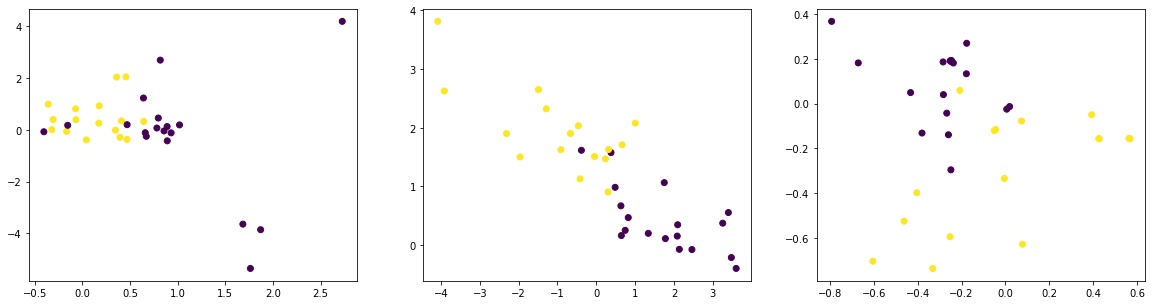

In [130]:
''' Hierarchical_tree'''
gamma = 5
model_tree = SkipGram(V=34)
val_tree = []
a,b = pathoftree(34)

for epoch in range(100):
    val = []
    for k in range(gamma):
        #shuffle V(graph)
        shuffled_node = np.arange(df.shape[0]) 
        np.random.shuffle(shuffled_node)
        for i in range(len(shuffled_node)):
            root = shuffled_node[i]
            walks = randomwalks(G =df, root = root)
            values = model_tree.train_hierarchical(G=df, walks = walks, leaf_pathes =a, leaf_path_signs=b)
            val.append(values)
    val_tree.append(np.sum(val)/(gamma*len(shuffled_node)))
embedding_tree = model_tree.Phi

''' no_tree'''
model_notree = SkipGram(V=34) 
val_notree = []
for epoch in range(100):
    val = []
    for k in range(gamma):
        shuffled_node = np.arange(df.shape[0]) 
        np.random.shuffle(shuffled_node)
        for i in range(len(shuffled_node)):
            root = shuffled_node[i]
            walks = randomwalks(G =df, root = root)
            values = model_notree.train(G=df, walks = walks)
            val.append(values)
    val_notree.append(np.sum(val)/(gamma*len(shuffled_node)))
embedding_notree = model_notree.Phi
    
''' Matrix Factorization'''
MF = MatrixFactorization(A = df, epoch = 100)
MF.sgd()
embedding_mf = MF.U

''' Visualization'''
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

x = embedding_tree[:,0] 
y = embedding_tree[:,1] 
ax1.scatter(x,y,c= label[:,1])

x2 = embedding_notree[:,0] 
y2 = embedding_notree[:,1] 
ax2.scatter(x2,y2,c= label[:,1])

x3 = embedding_mf[:,0]
y3 = embedding_mf[:,1]
ax3.scatter(x3,y3,c= label[:,1])
fig.show()

## Train-test split

In [122]:
''' 
Train-test split function을 제작. '''

def train_test_split(data, label, p=0.7):
    #data의 총 개수에서 p=0.7만큼의 인덱스를 구한다.
    n_train = int(np.ceil(data.shape[0] * p))
    n_test = data.shape[0] - n_train
    #바로 indexing 할 시 랜덤시행이 안되므로, random.choice로 p 비중 만큼 랜덤 인덱스 초이스를 한다. 
    idx_train = sorted(np.random.choice(range(data.shape[0]), n_train, replace=False))
    idx_test = np.delete(np.arange(data.shape[0]), idx_train)
    #앞서 구한 p 비율만큼의 인덱스를 이용해 train 데이터와 test 데이터를 뽑는다. 
    X_train = data[idx_train, :]
    X_test = data[idx_test, :]
    y_train = [label[idx] for idx in idx_train]
    y_test = [label[idx] for idx in idx_test]
    return X_train, X_test, y_train, y_test

## F1-score functioin

In [123]:
# F1 SCORE function을 만든다.
def F1score(y_pred, y):
    TP = 0; TN = 0; FP = 0; FN = 0
    for i in range(len(y)):
        # True Negative
        if (y_pred[i]==0 and y[i]==0):  
            TN += 1
        # True Positive
        elif (y_pred[i]==1 and y[i]==1):  
            TP += 1
        # False Positive
        elif y_pred[i]==1:  
            FP += 1
        # False negative
        else:
            FN += 1
        #구한 confusion matrix의 구성요소를 통해 f1 score를 도출한다. 
        #T오류가 발생해서,  TP=0인 경우 자동으로 0 반환하도록 설정
        if TP==0:
            return 0
        else:
            precision = TP / (TP+FP)
            recall = TP / (TP+FN)
            f1_score = 2*(precision*recall)/(precision+recall)
        return f1_score

## Logistic function

In [124]:
class Logistic:
    def __init__(self):
        #get initialized beta
        self.beta = []
        
        
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def train(self,X, y, lr=0.01, epoch=100,bias = True):
        if bias:
            #data에 상수항이 없으나, 로지스틱 회귀는 상수항이 필수이므로 상수항 추가
            X = np.concatenate((np.ones(shape=(X.shape[0],1)), X), axis=1)
        self.beta = np.random.randn(np.shape(X)[1])
        for i in range(epoch):
            #y 추정치 계산
            y_hat = self.sigmoid(X@self.beta)
            # gradient 계산
            grad = (y_hat - y).T@X
            #역전파
            self.beta -= lr*grad
            
    def predict(self,X,  thres=0.5, bias=True):
        if bias:
            X = np.concatenate((np.ones(shape=(X.shape[0],1)), X), axis=1)
        #test data에 대한 prediction 진행
        y_hat = self.sigmoid(X@self.beta)
        #thres 이상만 분류
        pred = y_hat > thres
        return list(map(int, pred))

## Implementation

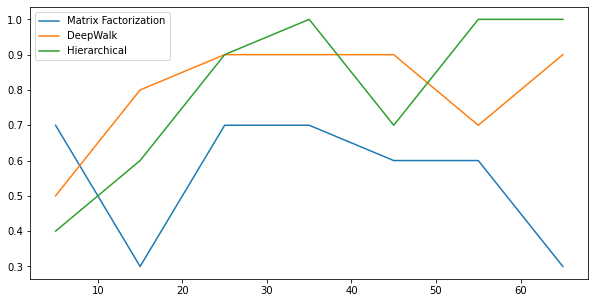

In [140]:
embeddings = [embedding_tree, embedding_notree, embedding_mf]
name = ["MatrixFactorization", "DeepWalk", "Hierarchical"]
f1s = []

for i in range(len(name)):
    meanF1 = []
    for p in range(5, 66, 10):
        logit = Logistic()
        proportion = p*0.01
        F1scores = []
        
        #run 10 times per every p, get average
        while len(F1scores)<10:
            
            X = embeddings[i]
            #기존에 사용하던 label은 인덱스 정보도 담겨 있어, y value만 추출
            X_train, X_test, y_train, y_test = train_test_split(X, label[:,1], p=proportion)

            logit.train(X_train,  y_train, epoch = 100)
            pred = logit.predict(X_test)
            
            f1 = F1score(pred, y_test)
            F1scores.append(f1)
        #f1 score의 10개의 mean을 사용
        meanF1.append(np.mean(F1scores))
    f1s.append(meanF1)
    
plt.figure(figsize=(10,5))
plt.plot(range(5,66,10), f1s[0], label="Matrix Factorization")
plt.plot(range(5,66,10), f1s[1], label="DeepWalk")
plt.plot(range(5,66,10), f1s[2], label="Hierarchical")
plt.legend()
plt.show()

matrix factorization의 경우 트레인 데이터가 적을때 상대적으로 높은 스코어를 보였다. 그러나 트레인 비율이 많아진다고 특별히 성능이 향상되지는 않는 모습을 보인다. 

Deepwalk와 Hierarchical의 경우 큰 차이를 보이지 않는다. Hierarchical이 어디까지나 approximation이라는 점을 고려하면, 이 둘의 성능 차이가 많이 나지 않는 것은 자연스러워 보인다. MF와 비교할 때, 둘 다 초반엔 스코어가 낮으나, 트레인 데이터의 비율이 증가함에 따라 성능이 올라간다. 이를 통해 충분히 적합이 되고 있음을 알 수 있다. 